<a href="https://colab.research.google.com/github/BrindhaGanesh/Breast_cancer_Thermography-detection/blob/main/Breast_Cancer_data_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"brindhaganesh","key":"6a873b63b7cd286558cd2621c93c7a5f"}'}

In [38]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [39]:
!pip install kaggle


In [40]:
!kaggle datasets download -d thilak02/breast-cancer-detection-using-thermography


Dataset URL: https://www.kaggle.com/datasets/thilak02/breast-cancer-detection-using-thermography
License(s): MIT
breast-cancer-detection-using-thermography.zip: Skipping, found more recently modified local copy (use --force to force download)


In [41]:
import zipfile

with zipfile.ZipFile('breast-cancer-detection-using-thermography.zip', 'r') as zip_ref:
    zip_ref.extractall('Breast_cancer')


In [42]:
base_path = "./Breast_cancer/BCD_Dataset"
label_categories = ['Sick','Unknown_class','normal']

In [43]:
image_paths = []
labels = []

In [44]:
import os
for i in label_categories:
  path = os.path.join(base_path,i)
  for img in os.listdir(path):
    image_paths.append(os.path.join(path,img))
    labels.append(i)

In [45]:
import pandas as pd
df = pd.DataFrame()
df['image_paths'] = image_paths
df['labels'] = labels

In [46]:
df.head()

image_paths labels
0  ./Breast_cancer/BCD_Dataset/Sick/T0192.1.1.S.2...   Sick
1  ./Breast_cancer/BCD_Dataset/Sick/T0274.1.1.S.2...   Sick
2  ./Breast_cancer/BCD_Dataset/Sick/T0282.1.1.S.2...   Sick
3  ./Breast_cancer/BCD_Dataset/Sick/T0209.1.1.S.2...   Sick
4  ./Breast_cancer/BCD_Dataset/Sick/T0376.1.1.D.2...   Sick

## Data quality check

In [47]:
print(f'no_of_duplicates :',{df.duplicated().sum()})
print(df.info())

no_of_duplicates : {np.int64(0)}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_paths  362 non-null    object
 1   labels       362 non-null    object
dtypes: object(2)
memory usage: 5.8+ KB
None


## Understand the data


checking image shapes for each class

we will plot sample images for each class and their shape

Class: Sick
Shape: (120, 160, 3)
Pixel Value Range: [0, 255]
Data Type: uint8
--------------------------------------------------
Class: Unknown_class
Shape: (64, 64, 3)
Pixel Value Range: [0, 255]
Data Type: uint8
--------------------------------------------------
Class: normal
Shape: (120, 160, 3)
Pixel Value Range: [0, 255]
Data Type: uint8
--------------------------------------------------


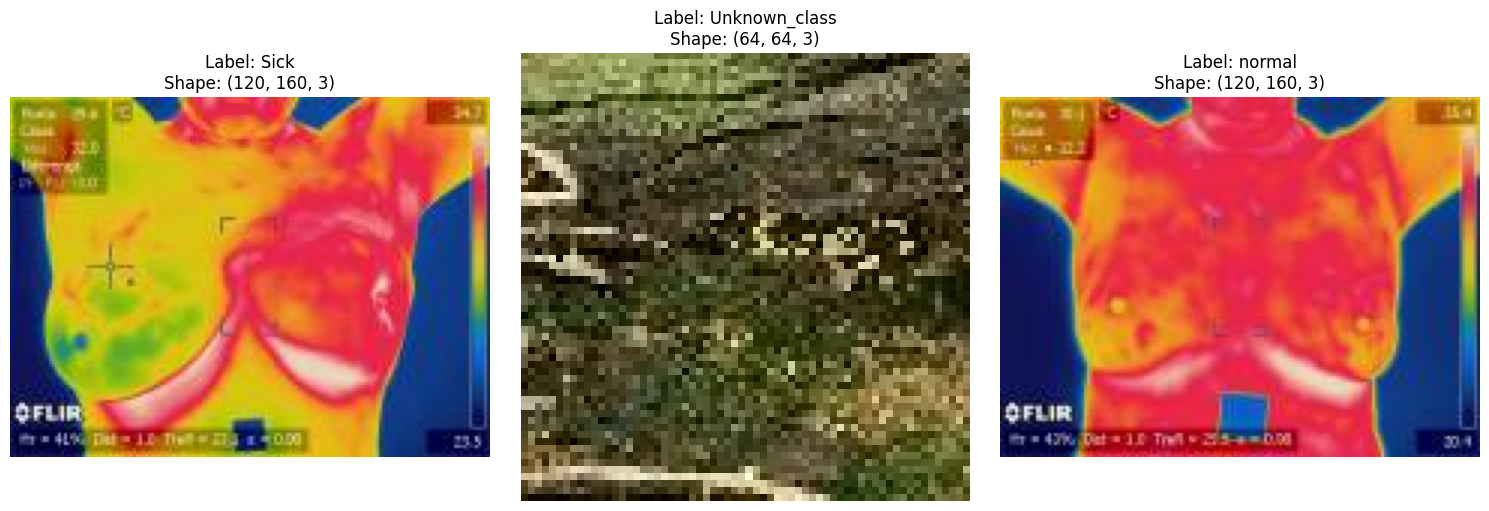

In [48]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Select one image per class
sample_images = df.groupby('labels').first().reset_index()

# Plot images
fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
for idx, row in sample_images.iterrows():
    img_path = row['image_paths']
    label = row['labels']
    img = Image.open(img_path)
    img_array = np.array(img)

    axes[idx].imshow(img)
    axes[idx].set_title(f"Label: {label}\nShape: {img_array.shape}")
    axes[idx].axis('off')

    # Print image properties
    print(f"Class: {label}")
    print(f"Shape: {img_array.shape}")
    print(f"Pixel Value Range: [{img_array.min()}, {img_array.max()}]")
    print(f"Data Type: {img_array.dtype}")
    print("-" * 50)

plt.tight_layout()
plt.show()

In [49]:
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageFilter
import numpy as np

# Optional dependencies
try:
    import cv2
    _HAS_CV2 = True
except Exception:
    _HAS_CV2 = False


def _to_uint8_for_display(arr):
    """
    Convert any dtype image to uint8 for consistent display without altering aspect.
    Preserves channels. Only used for visualization panels.
    """
    arr = np.asarray(arr)
    if arr.dtype == np.uint8:
        return arr
    arr_min, arr_max = float(arr.min()), float(arr.max())
    if arr_max == arr_min:
        return np.zeros_like(arr, dtype=np.uint8)
    scaled = (255.0 * (arr - arr_min) / (arr_max - arr_min)).astype(np.uint8)
    return scaled


def _ensure_rgb(arr):
    """
    Return an RGB array suitable for display.
    If input is single channel, stack to three channels.
    If input has an alpha channel, drop alpha.
    """
    arr = np.asarray(arr)
    if arr.ndim == 2:
        return np.stack([arr, arr, arr], axis=-1)
    if arr.ndim == 3 and arr.shape[2] == 4:
        return arr[:, :, :3]
    if arr.ndim == 3 and arr.shape[2] == 3:
        return arr
    # Fallback for unexpected shapes
    return _ensure_rgb(arr.squeeze())


def _to_gray_uint8(arr):
    """
    Convert to uint8 grayscale for processing that expects single channel.
    """
    a = np.asarray(arr)
    if a.ndim == 3 and a.shape[2] == 4:
        a = a[:, :, :3]
    if a.ndim == 3 and a.shape[2] == 3:
        # RGB to gray with standard luma weights
        g = 0.299 * a[:, :, 0] + 0.587 * a[:, :, 1] + 0.114 * a[:, :, 2]
    else:
        g = a
    return _to_uint8_for_display(g)


def _hist_eq_gray(arr_u8_gray):
    """
    Histogram equalization on a uint8 grayscale image.
    Uses OpenCV if present, otherwise PIL ImageOps.equalize.
    """
    if _HAS_CV2:
        return cv2.equalizeHist(arr_u8_gray)
    im = Image.fromarray(arr_u8_gray, mode="L")
    return np.array(ImageOps.equalize(im))


def _clahe_gray(arr_u8_gray, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    CLAHE on uint8 grayscale when OpenCV is available. Otherwise falls back to plain hist eq.
    """
    if _HAS_CV2:
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        return clahe.apply(arr_u8_gray)
    return _hist_eq_gray(arr_u8_gray)


def _gaussian_blur_rgb(arr_rgb_u8, k=5, sigma=1.2):
    if _HAS_CV2:
        return cv2.GaussianBlur(arr_rgb_u8, (k, k), sigma)
    im = Image.fromarray(arr_rgb_u8)
    return np.array(im.filter(ImageFilter.GaussianBlur(radius=sigma)))


def _median_rgb(arr_rgb_u8, k=3):
    if _HAS_CV2:
        return cv2.medianBlur(arr_rgb_u8, k)
    im = Image.fromarray(arr_rgb_u8)
    return np.array(im.filter(ImageFilter.MedianFilter(size=k)))


def _canny_edges(arr_u8_gray, t1=50, t2=150):
    if _HAS_CV2:
        return cv2.Canny(arr_u8_gray, t1, t2)
    # Simple Sobel fallback to approximate edges
    gx = np.array([[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]], dtype=float)
    gy = gx.T
    from scipy.signal import convolve2d  # if not available, replace with numpy pad ops
    sx = convolve2d(arr_u8_gray, gx, mode="same", boundary="symm")
    sy = convolve2d(arr_u8_gray, gy, mode="same", boundary="symm")
    mag = np.sqrt(sx**2 + sy**2)
    return _to_uint8_for_display(mag)


def _adaptive_thresh(arr_u8_gray):
    if _HAS_CV2:
        # mean adaptive threshold
        return cv2.adaptiveThreshold(arr_u8_gray, 255,
                                     cv2.ADAPTIVE_THRESH_MEAN_C,
                                     cv2.THRESH_BINARY, 11, 2)
    # Otsu fallback implemented via numpy
    hist, bins = np.histogram(arr_u8_gray.flatten(), bins=256, range=(0, 255))
    prob = hist.astype(float) / hist.sum()
    omega = np.cumsum(prob)
    mu = np.cumsum(prob * np.arange(256))
    mu_t = mu[-1]
    sigma_b_sq = (mu_t * omega - mu)**2 / (omega * (1.0 - omega) + 1e-9)
    t = np.nanargmax(sigma_b_sq)
    return (arr_u8_gray > t).astype(np.uint8) * 255


def visualize_preprocessing(sample_df,
                            path_col="image_paths",
                            label_col="labels",
                            per_class=1,
                            resize_to=(256, 256),
                            show=True):
    """
    Build a panel per class that shows different preprocessing results.
    sample_df is expected to have one row per chosen image already
    or you can pass the full df and set per_class for automatic sampling with groupby first.
    """
    df_in = sample_df.copy()

    # If more than one row per class and per_class is set, sample deterministically by first
    if per_class == 1:
        df_view = df_in.groupby(label_col).first().reset_index()
    else:
        df_view = (df_in.groupby(label_col)
                        .head(per_class)
                        .reset_index(drop=True))

    # Define preprocessing steps
    def to_original(arr):
        return _ensure_rgb(_to_uint8_for_display(arr))

    def to_gray(arr):
        return _to_gray_uint8(arr)

    def normalize_0_1(arr):
        a = np.asarray(arr).astype(np.float32)
        a_min, a_max = float(a.min()), float(a.max())
        if a_max == a_min:
            a = np.zeros_like(a, dtype=np.float32)
        else:
            a = (a - a_min) / (a_max - a_min)
        # For display scale back to uint8
        return _ensure_rgb((a * 255.0).astype(np.uint8))

    def contrast_stretch(arr, low=2, high=98):
        a = np.asarray(arr).astype(np.float32)
        p_low, p_high = np.percentile(a, [low, high])
        if p_high <= p_low:
            out = _to_uint8_for_display(a)
        else:
            a_cs = np.clip((a - p_low) / (p_high - p_low), 0, 1)
            out = (a_cs * 255.0).astype(np.uint8)
        return _ensure_rgb(out)

    def hist_eq(arr):
        g = _to_gray_uint8(arr)
        he = _hist_eq_gray(g)
        return _ensure_rgb(he)

    def clahe(arr):
        g = _to_gray_uint8(arr)
        he = _clahe_gray(g)
        return _ensure_rgb(he)

    def gaussian_blur(arr):
        rgb = _ensure_rgb(_to_uint8_for_display(arr))
        return _gaussian_blur_rgb(rgb, k=5, sigma=1.2)

    def median_blur(arr):
        rgb = _ensure_rgb(_to_uint8_for_display(arr))
        return _median_rgb(rgb, k=3)

    def edges(arr):
        g = _to_gray_uint8(arr)
        ed = _canny_edges(g)
        return _ensure_rgb(ed)

    def adapt_thresh(arr):
        g = _to_gray_uint8(arr)
        th = _adaptive_thresh(g)
        return _ensure_rgb(th)

    preprocessors = [
        ("Original", to_original),
        ("Gray", to_gray),
        ("Normalize 0 to 1", normalize_0_1),
        ("Contrast stretch", contrast_stretch),
        ("Hist eq", hist_eq),
        ("CLAHE", clahe),
        ("Gaussian blur", gaussian_blur),
        ("Median blur", median_blur),
        ("Edges", edges),
        ("Adaptive threshold", adapt_thresh),
    ]

    n_steps = len(preprocessors)
    n_rows = len(df_view)
    fig, axes = plt.subplots(n_rows, n_steps, figsize=(3.4 * n_steps, 3.4 * n_rows))

    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for r_idx, row in enumerate(df_view.itertuples(index=False)):
        img_path = getattr(row, path_col)
        label = getattr(row, label_col)

        # Load with PIL and keep raw dtype for thermal
        img = Image.open(img_path)
        # Optional resize for consistent grid look only
        if resize_to is not None:
            img = img.resize(resize_to)

        # Work in numpy for all transforms
        base = np.array(img)

        print(f"Class: {label}")
        print(f"Path: {img_path}")
        print(f"Shape: {base.shape}  dtype: {base.dtype}  value range: [{base.min()}, {base.max()}]")
        print("")

        for c_idx, (name, fn) in enumerate(preprocessors):
            try:
                out = fn(base)
                disp = _ensure_rgb(_to_uint8_for_display(out))
            except Exception as e:
                # Visualize a failure tile to make debugging easy
                h = resize_to[1] if resize_to is not None else base.shape[0]
                w = resize_to[0] if resize_to is not None else base.shape[1]
                disp = np.zeros((h, w, 3), dtype=np.uint8)
                name = f"{name}  failed"

                # Also print the error once per tile
                print(f"{name} error: {e}")

            ax = axes[r_idx, c_idx]
            ax.imshow(disp)
            if r_idx == 0:
                ax.set_title(name)
            ax.set_xticks([])
            ax.set_yticks([])

        axes[r_idx, 0].set_ylabel(f"{label}", rotation=90, size=11)

    plt.tight_layout()
    if show:
        plt.show()

    return fig, axes


Class: Sick
Path: ./Breast_cancer/BCD_Dataset/Sick/T0192.1.1.S.2013-09-06.00.jpg
Shape: (256, 256, 3)  dtype: uint8  value range: [0, 255]

Class: Unknown_class
Path: ./Breast_cancer/BCD_Dataset/Unknown_class/n01629819_421.JPEG
Shape: (256, 256, 3)  dtype: uint8  value range: [0, 255]

Class: normal
Path: ./Breast_cancer/BCD_Dataset/normal/T0017.1.1.S.2012-10-26.00.jpg
Shape: (256, 256, 3)  dtype: uint8  value range: [0, 255]



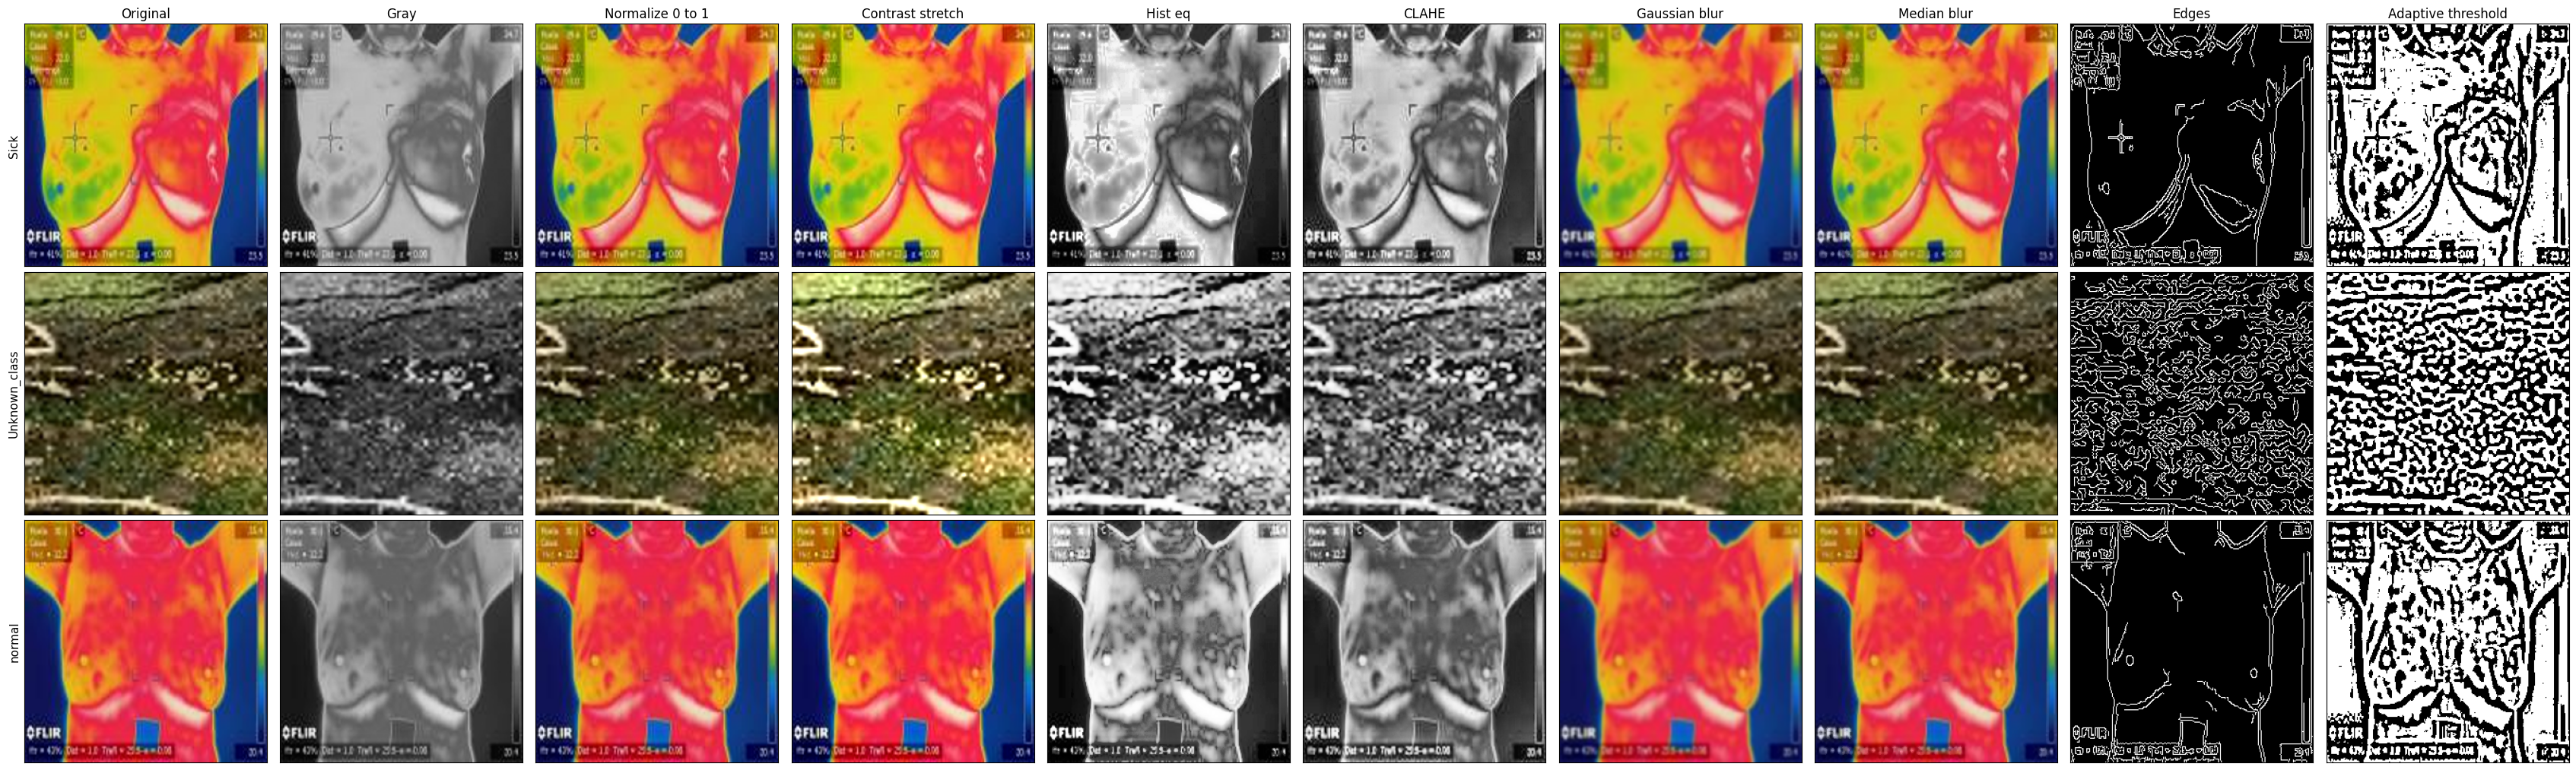

In [50]:
# sample_images = df.groupby('labels').first().reset_index()
fig, axes = visualize_preprocessing(sample_images,
                                    path_col="image_paths",
                                    label_col="labels",
                                    per_class=1,
                                    resize_to=(256, 256))


In [51]:


# Function to get image shape
def get_image_shape(img_path):
    try:
        img = Image.open(img_path)
        img_array = np.array(img)
        return img_array.shape
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None

# Add a column for shapes
df['shape'] = df['image_paths'].apply(get_image_shape)

# Filter out any failed loads
df = df.dropna(subset=['shape'])

# Summarize shapes by class
shape_summary = df.groupby('labels')['shape'].value_counts()
print("Shape distribution by class:")
print(shape_summary)

# Check unique shapes per class
unique_shapes_by_class = df.groupby('labels')['shape'].apply(lambda x: set(map(str, x)))
print("\nUnique shapes by class:")
for label, shapes in unique_shapes_by_class.items():
    print(f"{label}: {shapes}")

Shape distribution by class:
labels         shape        
Sick           (120, 160, 3)    100
Unknown_class  (64, 64, 3)      100
normal         (120, 160, 3)    162
Name: count, dtype: int64

Unique shapes by class:
Sick: {'(120, 160, 3)'}
Unknown_class: {'(64, 64, 3)'}
normal: {'(120, 160, 3)'}


#understanding data distribution

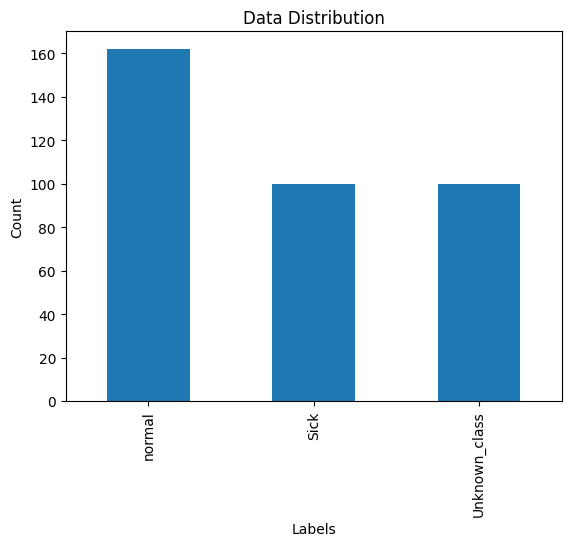

In [52]:
import matplotlib.pyplot as plt

df['labels'].value_counts().plot(kind='bar')
plt.title('Data Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [53]:
print(df['labels'].value_counts())


labels
normal           162
Sick             100
Unknown_class    100
Name: count, dtype: int64


As we can see in the visualization and value count print, The dataset is small and it is imbalanced.

This dataset is imbalanced and normal class is overrepresented. The model may bias toward predicting "normal". there are different ways to handle the imbalance. First we try with oversampling method:Here we duplicate the minority class count to match the Normal class count


1. first lets take a copz of the original dataset.
2. Goal: classify the class of the image.
    * Task : Multiclass single label classification
    

In [54]:
df = df.drop_duplicates(subset=["image_paths"]).copy()

In [55]:
df.head()

image_paths labels          shape
0  ./Breast_cancer/BCD_Dataset/Sick/T0192.1.1.S.2...   Sick  (120, 160, 3)
1  ./Breast_cancer/BCD_Dataset/Sick/T0274.1.1.S.2...   Sick  (120, 160, 3)
2  ./Breast_cancer/BCD_Dataset/Sick/T0282.1.1.S.2...   Sick  (120, 160, 3)
3  ./Breast_cancer/BCD_Dataset/Sick/T0209.1.1.S.2...   Sick  (120, 160, 3)
4  ./Breast_cancer/BCD_Dataset/Sick/T0376.1.1.D.2...   Sick  (120, 160, 3)

labels in the dataframe are strings, we need to convert them to integers because ml models understand intergers and not strings.  we will also map the integers for each class , this helps us when plotting confusion matrix during the model evaluation

In [56]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['encoded_labels'] = encoder.fit_transform(df['labels'])
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(label_mapping)

{'Sick': np.int64(0), 'Unknown_class': np.int64(1), 'normal': np.int64(2)}


1. Lets split the data (split train and test as 90% and 10% of total data respectively)
2. Split training and validation 80 and 20% respectively
3. oversample the training data to avoid trainig with bias on majority class

In [57]:
from sklearn.model_selection import train_test_split

train_val_df, test_df = train_test_split(
    df,
    test_size=0.1,
    stratify=df["encoded_labels"],
    random_state=42
)

In [58]:
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,
    stratify=train_val_df["encoded_labels"],
    random_state=42
)

after splitting lets understand how each class is distributed across datasets

               Train  Validation  Test
labels                                
Sick              72          18    10
Unknown_class     72          18    10
normal           116          29    17


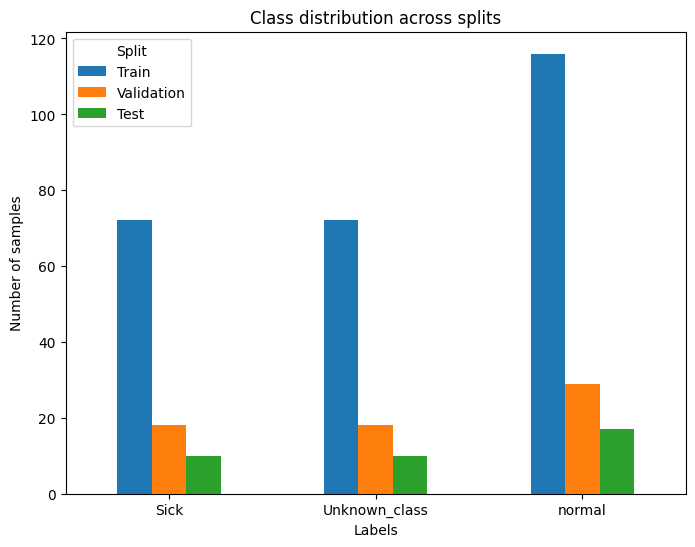

In [59]:
import matplotlib.pyplot as plt

# Count distribution
dist = {
    "Train": train_df["labels"].value_counts(),
    "Validation": val_df["labels"].value_counts(),
    "Test": test_df["labels"].value_counts(),
}

dist_df = pd.DataFrame(dist).fillna(0).astype(int)
print(dist_df)

# Plot side by side bar chart
dist_df.plot(kind="bar", figsize=(8,6))
plt.title("Class distribution across splits")
plt.ylabel("Number of samples")
plt.xlabel("Labels")
plt.xticks(rotation=0)
plt.legend(title="Split")
plt.show()


from this we can say that the distribution is similar to the original dataset before splitting. we have not did anything for imbalancing yet. one of the solution for imbalanced is 1. oversampling

* oversampling should be done only on training dataset


In [60]:
from sklearn.utils import resample

def oversample_train(frame, label_col="labels", seed=42):
    n = frame[label_col].value_counts().max()
    balanced = (frame.groupby(label_col, group_keys=False)
                .apply(lambda x: resample(x, replace=True, n_samples=n, random_state=seed))
                .reset_index(drop=True))
    return balanced
train_df_bal = oversample_train(train_df)

/tmp/ipython-input-3564401475.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: resample(x, replace=True, n_samples=n, random_state=seed))


since we have done some processing over the df like splitting, sampling, we will reset all the indexes for a clean code

In [61]:
train_df_bal.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [62]:
train_df_bal.head()

image_paths labels          shape  \
0  ./Breast_cancer/BCD_Dataset/Sick/T0198.2.1.S.2...   Sick  (120, 160, 3)   
1  ./Breast_cancer/BCD_Dataset/Sick/T0209.1.1.S.2...   Sick  (120, 160, 3)   
2  ./Breast_cancer/BCD_Dataset/Sick/T0346.1.1.D.2...   Sick  (120, 160, 3)   
3  ./Breast_cancer/BCD_Dataset/Sick/T0271.1.1.S.2...   Sick  (120, 160, 3)   
4  ./Breast_cancer/BCD_Dataset/Sick/T0394.1.1.S.2...   Sick  (120, 160, 3)   

   encoded_labels  
0               0  
1               0  
2               0  
3               0  
4               0

lets check if there is a dataleakage in all 3 datasets.

In [63]:
def check_overlap(a, b, name):
    overlap = set(a["image_paths"]) & set(b["image_paths"])
    print(f"overlap {name}:", len(overlap))
check_overlap(train_df_bal, val_df, "train vs val")
check_overlap(train_df_bal, test_df, "train vs test")
check_overlap(val_df, test_df, "val vs test")
dist = {
    "Train balanced": train_df_bal["labels"].value_counts(),
    "Validation": val_df["labels"].value_counts(),
    "Test": test_df["labels"].value_counts(),
}
print(pd.DataFrame(dist).fillna(0).astype(int))

overlap train vs val: 0
overlap train vs test: 0
overlap val vs test: 0
               Train balanced  Validation  Test
labels                                         
Sick                      116          18    10
Unknown_class             116          18    10
normal                    116          29    17


with these steps now we have balanced dataset for training our model
* now we can load our data set for our model: creating dataloaders using pytorch

In [64]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_paths']
        label = self.dataframe.iloc[idx]['encoded_labels']
        image = Image.open(img_path).convert('RGB')  # Ensure RGB format
        if self.transform:
            image = self.transform(image)
        return image, label

In [65]:
# Training transformations (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for model input
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/test transformations (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [66]:
train_dataset = ImageDataset(train_df_bal, transform=train_transform)
val_dataset   = ImageDataset(val_df, transform=val_test_transform)
test_dataset  = ImageDataset(test_df, transform=val_test_transform)

In [67]:
from torch.utils.data import DataLoader

batch_size = 32
num_workers = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True, persistent_workers=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True, persistent_workers=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True, persistent_workers=True)

In [68]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001, path='checkpoint.pth'):
        """
        Args:
            patience (int): Number of epochs to wait for improvement.
            min_delta (float): Minimum change in monitored metric to qualify as improvement.
            path (str): Path to save the best model.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model):
        # Check if validation loss improved
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            # Save the best model
            torch.save(model.state_dict(), self.path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

Pretrained model is used.

In [69]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import (
    ResNet50_Weights,
    EfficientNet_B0_Weights,
    DenseNet121_Weights,
    MobileNet_V3_Small_Weights,
    ViT_B_16_Weights,
)

def get_model(model_name: str, num_classes: int = 3, freeze_backbone: bool = False):
    """
    Returns a model and a suggested learning rate.
    Set freeze_backbone True to train only the classifier head for a few epochs.
    """
    model_name = model_name.lower()
    if model_name == "resnet50":
        weights = ResNet50_Weights.DEFAULT
        model = models.resnet50(weights=weights)
        in_feats = model.fc.in_features
        model.fc = nn.Linear(in_feats, num_classes)
        lr = 1e-4

    elif model_name == "efficientnet_b0":
        weights = EfficientNet_B0_Weights.DEFAULT
        model = models.efficientnet_b0(weights=weights)
        in_feats = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_feats, num_classes)
        lr = 1e-3

    elif model_name == "densenet121":
        weights = DenseNet121_Weights.DEFAULT
        model = models.densenet121(weights=weights)
        in_feats = model.classifier.in_features
        model.classifier = nn.Linear(in_feats, num_classes)
        lr = 1e-3

    elif model_name == "mobilenet_v3_small":
        weights = MobileNet_V3_Small_Weights.DEFAULT
        model = models.mobilenet_v3_small(weights=weights)
        in_feats = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(in_feats, num_classes)
        lr = 1e-3

    elif model_name == "vit_b_16":
        weights = ViT_B_16_Weights.DEFAULT
        model = models.vit_b_16(weights=weights)
        in_feats = model.heads.head.in_features
        model.heads.head = nn.Linear(in_feats, num_classes)
        lr = 1e-4

    elif model_name == "simple_cnn":
        # small custom CNN as a sanity baseline
        class SimpleCNN(nn.Module):
            def __init__(self, num_classes):
                super().__init__()
                self.features = nn.Sequential(
                    nn.Conv2d(3, 32, 3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2),
                    nn.Conv2d(32, 64, 3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2),
                    nn.Conv2d(64, 128, 3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2),
                )
                self.classifier = nn.Sequential(
                    nn.AdaptiveAvgPool2d(1),
                    nn.Flatten(),
                    nn.Linear(128, num_classes),
                )
            def forward(self, x):
                x = self.features(x)
                x = self.classifier(x)
                return x
        model = SimpleCNN(num_classes)
        lr = 1e-3

    else:
        raise ValueError(f"Model {model_name} not supported.")

    if freeze_backbone:
        # unfreeze final classifier only
        for p in model.parameters():
            p.requires_grad = False
        if hasattr(model, "fc") and isinstance(model.fc, nn.Linear):
            for p in model.fc.parameters():
                p.requires_grad = True
        elif hasattr(model, "classifier"):
            for p in model.classifier.parameters():
                p.requires_grad = True
        elif hasattr(model, "heads"):
            for p in model.heads.parameters():
                p.requires_grad = True

    return model, lr

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# build model
model_name = "simple_cnn"  # or efficientnet_b0 densenet121 mobilenet_v3_small vit_b_16
model, lr = get_model(model_name, num_classes=3)  # your factory from earlier
model = model.to(device)
class_counts = torch.tensor([72, 72, 116], dtype=torch.float)
weights = 1.0 / class_counts  # inverse frequency
weights = weights / weights.sum()  # normalize if needed

#criterion = nn.CrossEntropyLoss(weight=weights.to(device))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

Device: cuda


In [71]:


def accuracy_from_logits(logits, targets):
    preds = logits.argmax(1)
    return (preds == targets).float().mean().item() * 100.0

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    total = 0

    for images, labels in tqdm(loader, leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        running_loss += loss.item() * batch_size
        running_acc  += accuracy_from_logits(outputs, labels) * batch_size
        total += batch_size

    return running_loss / total, running_acc / total

def validate_one_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)
            loss = criterion(outputs, labels)

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size
            running_acc  += accuracy_from_logits(outputs, labels) * batch_size
            total += batch_size

    return running_loss / total, running_acc / total

# simple training loop with early stop on validation loss if it gets worse N times
num_epochs = 30
patience = 5
best_val_loss = float("inf")
bad_epochs = 0
best_path = "best_model_simple.pth"

train_history = []
val_history = []

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    va_loss, va_acc = validate_one_epoch(model, val_loader, criterion)

    train_history.append((tr_loss, tr_acc))
    val_history.append((va_loss, va_acc))

    print(f"Epoch {epoch:03d}  train loss {tr_loss:.4f} acc {tr_acc:.2f}  val loss {va_loss:.4f} acc {va_acc:.2f}")

    if va_loss < best_val_loss - 1e-4:
        best_val_loss = va_loss
        bad_epochs = 0
        torch.save(model.state_dict(), best_path)
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

# load best weights
model.load_state_dict(torch.load(best_path, map_location=device))

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 001  train loss 1.0986 acc 34.48  val loss 1.0690 acc 50.77


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 002  train loss 1.0568 acc 44.54  val loss 1.0308 acc 63.08


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 003  train loss 1.0074 acc 60.34  val loss 1.1036 acc 41.54


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 004  train loss 0.9680 acc 62.64  val loss 0.9744 acc 58.46


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 005  train loss 0.8846 acc 65.52  val loss 0.8842 acc 69.23


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 006  train loss 0.8136 acc 68.97  val loss 0.8822 acc 69.23


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 007  train loss 0.7288 acc 71.55  val loss 0.7488 acc 70.77


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 008  train loss 0.7033 acc 69.83  val loss 0.7048 acc 67.69


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 009  train loss 0.6727 acc 72.99  val loss 0.6659 acc 72.31


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 010  train loss 0.6126 acc 74.43  val loss 0.6438 acc 75.38


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 011  train loss 0.5738 acc 76.44  val loss 0.6320 acc 76.92


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 012  train loss 0.5420 acc 75.57  val loss 0.5519 acc 81.54


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 013  train loss 0.4889 acc 80.17  val loss 0.6592 acc 73.85


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 014  train loss 0.5197 acc 78.45  val loss 0.4975 acc 84.62


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 015  train loss 0.4872 acc 78.74  val loss 0.6753 acc 69.23


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 016  train loss 0.4770 acc 81.03  val loss 0.4824 acc 76.92


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 017  train loss 0.4356 acc 82.76  val loss 0.4783 acc 76.92


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 018  train loss 0.4014 acc 82.47  val loss 0.4278 acc 83.08


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 019  train loss 0.3861 acc 83.62  val loss 0.4636 acc 86.15


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 020  train loss 0.3797 acc 81.61  val loss 0.4034 acc 84.62


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 021  train loss 0.3660 acc 84.77  val loss 0.4179 acc 86.15


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 022  train loss 0.3796 acc 81.61  val loss 0.4162 acc 83.08


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 023  train loss 0.3904 acc 80.46  val loss 0.3912 acc 83.08


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 024  train loss 0.3651 acc 82.47  val loss 0.4139 acc 83.08


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 025  train loss 0.3350 acc 85.92  val loss 0.4012 acc 81.54


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 026  train loss 0.3479 acc 85.06  val loss 0.4057 acc 81.54


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 027  train loss 0.3312 acc 84.48  val loss 0.3852 acc 84.62


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 028  train loss 0.3227 acc 84.48  val loss 0.3911 acc 84.62


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 029  train loss 0.3205 acc 86.78  val loss 0.3547 acc 87.69


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 030  train loss 0.3349 acc 84.77  val loss 0.3675 acc 84.62


<All keys matched successfully>

In [72]:
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
import numpy as np
import torch

def predict_all(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            pred = out.argmax(1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
    return np.array(y_true), np.array(y_pred)

y_true, y_pred = predict_all(model, test_loader, device)

print("Accuracy:", (y_true == y_pred).mean() * 100.0)
print("Balanced accuracy:", balanced_accuracy_score(y_true, y_pred) * 100.0)

# make sure the order matches your encoded labels
target_names = ["Sick", "Unknown_class", "normal"]
print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
print("Confusion matrix\n", cm)

Accuracy: 83.78378378378379
Balanced accuracy: 81.37254901960786
               precision    recall  f1-score   support

         Sick       0.75      0.60      0.67        10
Unknown_class       1.00      0.90      0.95        10
       normal       0.80      0.94      0.86        17

     accuracy                           0.84        37
    macro avg       0.85      0.81      0.83        37
 weighted avg       0.84      0.84      0.83        37

Confusion matrix
 [[ 6  0  4]
 [ 1  9  0]
 [ 1  0 16]]


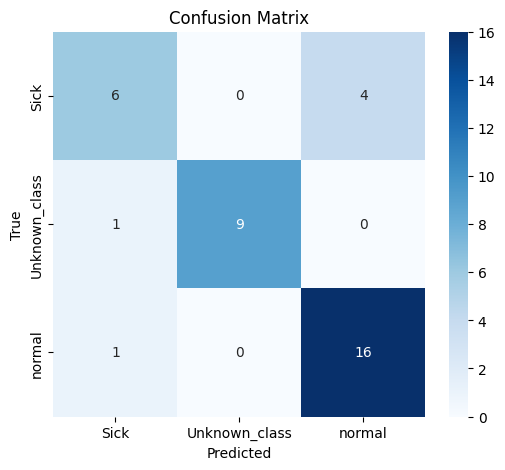

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])

# plot with seaborn heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Understanding the evaluation metrics
# accuracy = (Total Correct Predictions) / (Total Samples)
32/37 = 0.8648
(sum of all diagnoal elemnets/ sum of all elements)

* Looking only at accuracy we canot overall correct predictions, we cannot understand the per class performance. It does not tell about the bias in the performance of the model.. to fine tune the model or change the approach the model behaves we need to understand the per class performance like how many correct classfications per class, how many incorerct to improve the model performance.

* To understand per-class performance we need:

  Confusion matrix (shows correct and wrong counts per class)
   recall,Precision, F1-score (summarize per-class performance)



#### Recall = True Positives (TP) / (True Positives + False Negatives) explains about false negatives.

among all true Sick samples, how many predicted sick are actually correct
out of 10 sick sampples 6 are actually predicted correct and 4 are predicted as normal

recall of sick = 6/10 = 0.6


# Balanced accuracy

This tells me how we i did based on each class, this metric treats all class equally important as we are avg recall scores of each class





# Precision = Precision = True Positives (TP) / (True Positives + False Positives)

it tells how confident when we are predicting
with recall(sick) - 0.4 of sick we missed but it does not talk about how many false positives in other classes, for that we need precision

for example , perecision score of sick class tells among all samples predicted Sick, how many are actually Sick?

Precision cares about who got wrongly pulled into the class.

Recall cares about who got wrongly left out of the class.



# f1 score = 2 * (Precision * Recall) / (Precision + Recall).
this score gives a balanced overview when we need to consider both false positives and false negatives

harmonic mean of Precision and Recall for Sick






#Understanding our classification report

unknown classes are classifying correctly , perefcet scores for precision, recall, f1score

Normal class (17 samples)

Precision = 0.80, Recall = 0.94, F1 = 0.86  

Sick class (10 samples)

Precision = 0.86

Recall = 0.60 we are missing 40% of Sick patients

cuurently our model is not performaing well on sick classes


# Training transformations (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for model input
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

these are the transformation we used for our image, these are baisc transformations of rbg image, i beleive that is why our unknown class predictions are spot on, for the rest of the 2 classes they are thermal images, we can try with different preprocessing techniques to extract bettwe fetures for them
